<h1>Revisiting the ML model to refine the feature set to make the output more meaningful</h1>
<p>This notebook looks at factors influencing goalie performance (save percentage) and the injury (via t_tests) implementing them in a Logistic Regression ml model</p>

In [33]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import stats
import sqlite3
from joblib import dump, load
pd.set_option('display.max_rows', 500)

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [34]:
DB = "../assests/hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [35]:
def riskfunc(x):
    """Estimate the increased risk factor by player playing
    """
    y = x**3+0.37*(x**2)-0.2572*x+0.0118
    return np.round(10**y,1)

def risk(team_value,year_value,game_date,add_min=0):
    #add_min are the additional minutes

    #get unique ids
    q = ("""SELECT * 
        FROM player_log 
        WHERE team_id=\"{0}\"
        AND (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {1}
        AND date_game < \"{2}\"
        GROUP BY player_id
        """.format(team_value,int(year_value) + .66,game_date))

    ids = run_query(q)

    #now generate data for season

    prodf = pd.DataFrame(columns=['player_id','team_id','opp_id','date_game','age','rest_days','min_season',
                                    'shots_against','save_pct','min3W','sa3W','svepct3W','future_save_pct','injured'])
    row = 0
    for each_id in ids['player_id']:
        q = ("""SELECT * 
        FROM player_log 
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) > {0}
        AND date_game < \"{1}\"
        AND player_id = \"{2}\"
        """.format(int(year_value) + .66,game_date,each_id))
        season_logs = run_query(q)
        season_logs['date_game'] = season_logs['date_game'].astype('datetime64') #convert to datetime
        season_logs['time_on_ice'] = season_logs['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+season_logs['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60

        for r,game in season_logs[-1:].iterrows():
            prodf.loc[row,'player_id'] = season_logs.loc[r,'player_id']
            prodf.loc[row,'team_id'] = season_logs.loc[r,'team_id']
            prodf.loc[row,'opp_id'] = season_logs.loc[r,'opp_id']
            prodf.loc[row,'date_game'] = season_logs.loc[r,'date_game']
            prodf.loc[row,'age'] = season_logs.loc[r,'age']
            prodf.loc[row,'rest_days'] = (season_logs.loc[r,'date_game']-season_logs.loc[r-1,'date_game']).days+add_min/15
            prodf.loc[row,'min_season'] = season_logs.loc[:(r-1),'time_on_ice'].sum()+add_min
            prodf.loc[row,'shots_against'] = season_logs.loc[:(r-1),'shots_against'].sum()
            prodf.loc[row,'save_pct'] = np.round(season_logs.loc[:(r-1),'saves'].sum()/season_logs.loc[:(r-1),'shots_against'].sum(),3)

            window = (season_logs.loc[r,'date_game']>season_logs['date_game'])&(season_logs['date_game']>(season_logs.loc[r,'date_game']-timedelta(21)))

            prodf.loc[row,'min3W'] = season_logs.loc[window,'time_on_ice'].sum()-add_min/5
            prodf.loc[row,'sa3W'] = season_logs.loc[window ,'shots_against'].sum()
            prodf.loc[row,'svepct3W'] = season_logs.loc[window,'saves'].sum()/season_logs.loc[window,'shots_against'].sum()
            prodf.loc[row,'injured'] = season_logs.loc[r,'injured']    
            prodf.loc[row,'pre_inj'] = season_logs.loc[r,'pre_inj']
        row+=1
    columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W']
    #columns = ['age','min_season','rest_days','pre_inj']
    probs = ml_model.predict_proba(num_pipeline.fit_transform(prodf[columns]))[:,1]
    riskfunc(probs)
    return dict(zip(ids['player_id'].to_list(),riskfunc(probs)))

def games_remaining(team_id,year_value,game_date):
    """Estimates the minutes remaining in the season (exluding overtimes)"""
    #get all the games for the team that season
    q = ("""SELECT * 
        FROM team_log 
        WHERE (CAST(SUBSTR(date_game,1,4) AS FLOAT)+CAST(SUBSTR(date_game,6,7) AS FLOAT)/12) < {0}
        AND date_game >=  \"{1}\"
        AND team_id = \"{2}\"
        """.format(int(year_value) + 1.66,game_date,team_id))
    team_logs = run_query(q)
    
    return team_logs.shape[0]*60,team_logs

<h2>First look at how the existing model behaves with time</h2>

In [5]:
#import data
goalie_data =pd.read_csv('advancedgoaliestats_withadditionalgoalies.csv')
goalie_data.drop(columns=['Unnamed: 0'],inplace=True)
gd_players = goalie_data.groupby('player_id').max()
#get list of players with one reported injury
player_inj_list = gd_players[gd_players['injured']==1].index
goalie_data_inj = pd.DataFrame(columns=goalie_data.columns)
#train model on players from this list
for players in player_inj_list:
    goalie_data_inj = goalie_data_inj.append(goalie_data[goalie_data['player_id']==players].copy())
goalie_data_inj[['rest_days','shots_against','sa3W','pre_inj','injured']] = goalie_data_inj[['rest_days','shots_against','sa3W','pre_inj','injured']].astype(int)
#goalie_data_inj.loc[goalie_data_inj['pre_inj']>=1,'pre_inj'] = 1


In [6]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load

<h2>Now Fit</h2>

In [7]:
statDF = pd.DataFrame(columns = ['Feature', 'Statistic', 'P-Value'])

np.random.seed(34)
#get random sample for each outcome
no_injury = goalie_data_inj[goalie_data_inj['injured']==0].iloc[np.random.randint(0,50000,830),:]
injury = goalie_data_inj[goalie_data_inj['injured']==1]
cols = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
better_names = ['Age','Minutes Played (season)','Rest Days','Shots', 'Save %', 'Minutes last 3W', 'Saves last 3W', 'Save pct last 3W','Previous Injury']
for i,c in enumerate(cols):
    #calculate the stat
    statistic = stats.ttest_ind(no_injury[c],injury[c])
    statDF = statDF.append(dict(zip(statDF.columns,[better_names[i],statistic[0],statistic[1]])),ignore_index=True)
statDF

,Feature,Statistic,P-Value
0,Age,-3.098876,1.974312e-03
1,Minutes Played (season),1.859571,6.311844e-02
2,Rest Days,0.729492,4.658013e-01
3,Shots,1.112692,2.659975e-01
4,Save %,2.028805,4.263336e-02
5,Minutes last 3W,0.699691,4.842161e-01
6,Saves last 3W,-0.539252,5.897832e-01
7,Save pct last 3W,1.779584,7.532229e-02
8,Previous Injury,-9.965727,8.919688e-23


In [8]:
no_injury = goalie_data_inj[goalie_data_inj['injured']==0].sample(frac=1)
injury= goalie_data_inj[goalie_data_inj['injured']==1].sample(frac=1)

In [23]:
ml_model = LogisticRegression()
b = 1 #balance factor
# #randomise the no injury data
# no_injury = goalie_data_inj[goalie_data_inj['injured']==0].sample(frac=1)
# inj_no = goalie_data_inj[goalie_data_inj['injured']==1].shape[0]
# i = 0
# data = no_injury.iloc[(i*inj_no):((i+1)*inj_no)]
# data = data.append(goalie_data_inj[goalie_data_inj['injured']==1])
# mask = (np.random.rand(data.shape[0]) < 0.8)
# train = data[mask].sample(frac=1)
# test = data[~mask].sample(frac=1)

#split data into those with and without injury
no_injury = goalie_data_inj[goalie_data_inj['injured']==0].sample(frac=1)
injury= goalie_data_inj[goalie_data_inj['injured']==1].sample(frac=1)

#split injuries data further
mask = (np.random.rand(injury.shape[0]) < 0.8)
traininj = injury[mask].sample(frac=1)
testinj = injury[~mask].sample(frac=1)

#split noinjuries
testnoinj = no_injury[:testinj.shape[0]*59]
trainnoinj = no_injury[testinj.shape[0]*59:]
test = (testinj.append(testnoinj)).sample(frac=1)

#now run multiple times with resampling
for i in range(10):
    #add no injuries
    train = trainnoinj.sample(traininj.shape[0])
    #add injuries
    train = train.append(traininj)
    train = train.sample(frac=1) #mix it up

    #create pipeline for standard scaling
    num_pipeline = Pipeline([('std_scaler',StandardScaler())])
    #select columns to fit
    columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
    #columns = ['pre_inj']
    #columns = ['age','min_season','rest_days','pre_inj','save_pct']

    #get training data
    trainX = num_pipeline.fit_transform(train[columns])
    trainY = np.array(train['injured'])
    testX = num_pipeline.fit_transform(test[columns])
    testY = np.array(test['injured'])

    ml_model.fit(trainX,trainY)

#run on training data
predicted = ml_model.predict(trainX)
true_positives = np.sum((predicted==1)&(trainY==1))
false_positives = np.sum((predicted==1)&(trainY==0))
true_negatives = np.sum((predicted==0)&(trainY==0))
false_negatives = np.sum((predicted==0)&(trainY==1))

print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))
confusion_matrix(predicted,trainY)

Precision is 0.62
Recall is 0.49


array([[486, 352],
       [205, 339]], dtype=int64)

Precision is 0.029907
Recall is 0.64


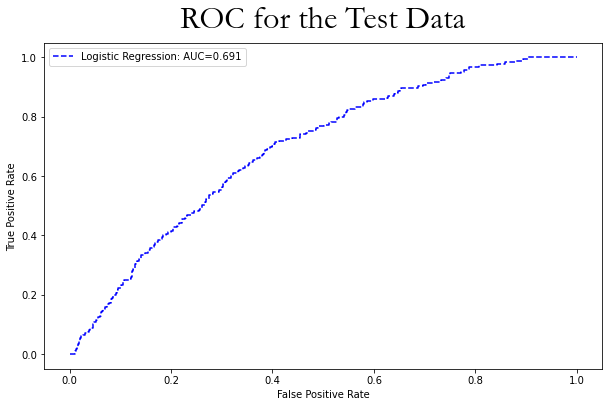

In [27]:
#try on test data

predicted = ml_model.predict(testX)
true_positives = np.sum((predicted==1)&(testY==1))
false_positives = np.sum((predicted==1)&(testY==0))
true_negatives = np.sum((predicted==0)&(testY==0))
false_negatives = np.sum((predicted==0)&(testY==1))

print("Precision is %03f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))
confusion_matrix(predicted,testY)

fpr,tpr,thresholds = roc_curve(testY,
                               ml_model.predict_proba(testX)[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,"b--",label="Logistic Regression: AUC=%0.3f"%(roc_auc_score(testY,ml_model.predict_proba(testX)[:,1])))
#plt.plot(thresholds,recall[:-1],"g-",label="recall")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for the Test Data',font='Garamond',fontsize=32,pad = 15)
plt.savefig('ROCfortheTestData_LogR.png')
plt.show()

<h2>Try on all the data</h2>

In [25]:
gd = goalie_data.sample(frac=1)
predicted = ml_model.predict(num_pipeline.fit_transform(gd[columns]))
gdY = np.array(gd['injured'])
true_positives = np.sum((predicted==1)&(gdY==1))
false_positives = np.sum((predicted==1)&(gdY==0))
true_negatives = np.sum((predicted==0)&(gdY==0))
false_negatives = np.sum((predicted==0)&(gdY==1))
print(false_positives)
print("Precision is %0.3f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.3f" % (true_positives/(true_positives+false_negatives)))

print('true_positives',true_positives)
print('false_positive',false_positives)
print('false_negative',false_negatives)
print('true_negative',true_negatives)

21681
Precision is 0.025
Recall is 0.647
true_positives 567
false_positive 21681
false_negative 309
true_negative 45602


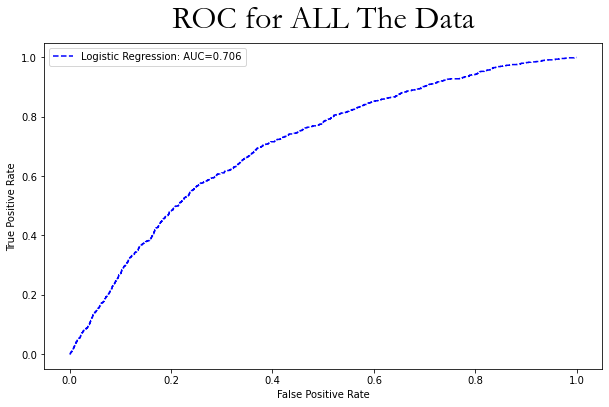

In [111]:
fpr,tpr,thresholds = roc_curve(np.array(gd['injured']),
                               ml_model.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,"b--",label="Logistic Regression: AUC=%0.3f"%(roc_auc_score(np.array(gd['injured']),ml_model.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])))
#plt.plot(thresholds,recall[:-1],"g-",label="recall")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ALL The Data',font='Garamond',fontsize=32,pad = 15)
plt.savefig('ROCforAlltheData.png')
plt.show()

In [32]:
ypred = ml_model.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1]
yreal = np.array(gd['injured'])
for m in np.arange(0,1,.1):
    tp = ((ypred>=m)&(yreal==1)).sum()
    fp = ((ypred>=m)&(yreal==0)).sum()
    fn = ((ypred<=m)&(yreal==1)).sum()

    print("Trial %0.2f:Identified %s of %s, Precision of %0.3f and Recall of %0.2f.  TP:%d,FP:%d"%(m,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn),tp,fp))

Trial 0.00:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67283
Trial 0.10:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67283
Trial 0.20:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67283
Trial 0.30:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67017
Trial 0.40:Identified 856 of 876, Precision of 0.014 and Recall of 0.98.  TP:856,FP:59325
Trial 0.50:Identified 567 of 876, Precision of 0.025 and Recall of 0.65.  TP:567,FP:21681
Trial 0.60:Identified 338 of 876, Precision of 0.032 and Recall of 0.39.  TP:338,FP:10099
Trial 0.70:Identified 183 of 876, Precision of 0.034 and Recall of 0.21.  TP:183,FP:5217
Trial 0.80:Identified 61 of 876, Precision of 0.034 and Recall of 0.07.  TP:61,FP:1733
Trial 0.90:Identified 3 of 876, Precision of 0.019 and Recall of 0.00.  TP:3,FP:151
